In [1]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 


In [2]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


##### After exploring the data a bit I decided some columns won't be necessary for this prediction

In [3]:
df2 = df1.drop(['society','balcony','availability', 'area_type'],axis='columns')


##### Cleaning the data

Handaling the Null data
                                             

In [4]:
df3 = df2.copy()
df3.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [5]:
df3.dropna(subset=['size','location'], inplace=True)

The size data is in different formats. I am making a new feature (integer) with just the BHK no.   

In [6]:

print(df3['size'].unique())

df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))



['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' '9 Bedroom' '27 BHK' '10 Bedroom'
 '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom' '14 BHK' '8 BHK'
 '12 Bedroom' '13 BHK' '18 Bedroom']


In [7]:
print('new BHK Feature', df3['bhk'].unique())

new BHK Feature [ 2  4  3  6  1  8  7  5 11  9 27 10 19 16 43 14 12 13 18]


73 entries doesn't have data on no of baths. Instead of dropping then I decided to set bath no to (BHK + 2). 

In [8]:
df3.bath.fillna(df3['bhk']+2, inplace=True)

After exploring the total_sqft data I noticed the data is in different formats. I dicided to go on with the data of 'xxxx' & 'xxxx-xxxx' format. 

In [9]:

def is_float(x):
    try:
        float(x)
    except:
        return False
    return True
    
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
                                                                                               

In [10]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


### Feature Engineering
For removing outliers now adding price_per_sqft column

In [11]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [12]:
df5.to_csv("bhp.csv",index=False)

There are many locations which has just one house listed. Let's rename those to 'others'

In [13]:
print(len(df5.location.unique()))
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)

location_stats_less_than_10 = location_stats[location_stats<=10]

df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

len(df5.location.unique()) #Reduced the unique locations from 1287 to 241

1298


241

In [14]:
df5[df5.total_sqft/df5.bhk<150].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
89,Rajaji Nagar,6 Bedroom,710.0,6.0,160.0,6,22535.211268
119,Hennur Road,2 Bedroom,276.0,3.0,23.0,2,8333.333333
129,Vishwapriya Layout,7 Bedroom,950.0,7.0,115.0,7,12105.263158
176,Kumaraswami Layout,5 Bedroom,600.0,3.0,85.0,5,14166.666667


Some data are suspicious. Like you can't build a 8 BHK house in 600 sqft. We have to remove them.

In [15]:
# removing some houses by keeping our minimum thresold per bhk to be 250 sqft
print(df5.shape)
df6 = df5[~(df5.total_sqft/df5.bhk<250)]
df6.shape

(13257, 7)


(12645, 7)

There is a a wide variance in price per sqft. We can remove some outliers by using mean and standard deviation. 

In [16]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-  st)) & (subdf.price_per_sqft<=(m+ st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10436, 7)

It is unusual to have 2 more bathrooms than number of bedrooms in a home.

In [17]:
df8 = df7[df7.bath<df7.bhk+2]
df8.shape

(10288, 7)


##### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

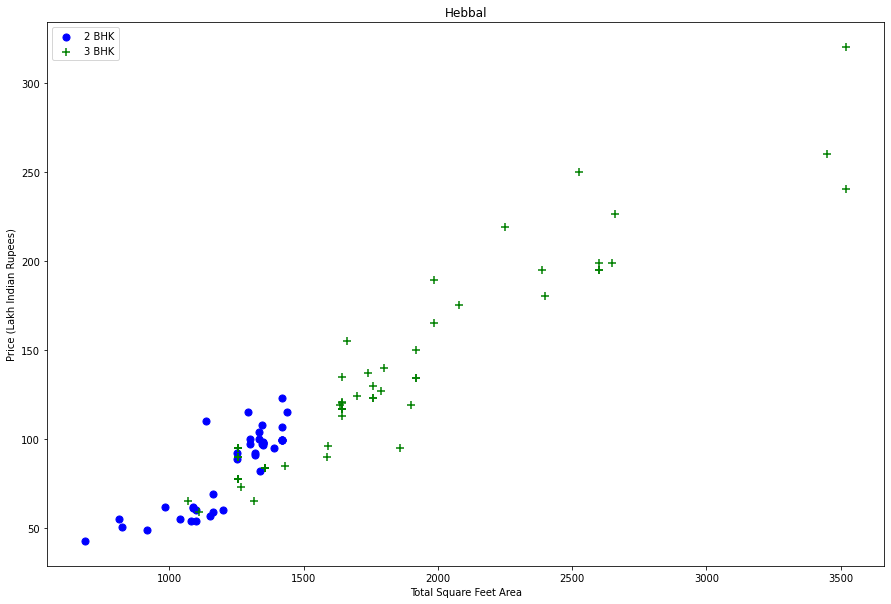

In [18]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Hebbal")

We should  remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). 

In [19]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df9 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df9.shape

(7442, 7)

In [20]:

df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


### Use One Hot Encoding For Location


In [21]:
dummies = pd.get_dummies(df10.location)
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')

df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df12 = df11.drop(['location'],axis='columns')
df12.head(2)

In [23]:
X = df12.drop(['price'],axis='columns')
y = df12.price

### Building a Model

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [32]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8399429849160549

In [26]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.83125548, 0.80375462, 0.85377745, 0.85552128, 0.87510267])


### Find best model using GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.843882,{'normalize': True}
1,lasso,0.699351,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.728908,"{'criterion': 'mse', 'splitter': 'random'}"


#### So here linear_regressing gave the best score
### Export the tested model to a pickle file

In [28]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

#### Export location and column information to a file that will be useful later on in our prediction application

In [29]:

import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))